In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats

%matplotlib inline

In [29]:
pd.options.display.max_columns = None
trainData  = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")
allData = pd.concat((trainData.iloc[:,:-1], testData.iloc[:,:])).reset_index(drop=True)
#allData.head()
#allData.describe()
#allData.info(verbose=True, null_counts=True)

In [30]:
#Coverting the data type according to data description 
toCovert = ["MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold", "MoSold"]
allData[toCovert] = allData[toCovert].astype("str")

## Missing Values

In [31]:
#1. remove columns with more than 1/3 NAs
naSum = allData.isnull().sum()
naValue = naSum[naSum!=0]
highNaN = naValue[naValue >= 1000].index
allData.drop(highNaN, axis = 1, inplace = True)
#restNaN = highNaN.symmetric_difference(naValue.index)
#allData[restNaN].head()

In [32]:
# discovered many NAs come from the same row, drop the row
naRow = allData["BsmtFinSF1"].isnull()[allData["BsmtFinSF1"].isnull() == True].index
allData.drop(allData.index[naRow], inplace = True)
allData = allData.reset_index(drop = True)
naRow2 = allData["Exterior1st"].isnull()[allData["Exterior1st"].isnull() == True].index
allData.drop(allData.index[naRow2], inplace = True)
allData = allData.reset_index(drop = True)
naRow3 = allData["GarageCars"].isnull()[allData["GarageCars"].isnull() == True].index
allData.drop(allData.index[naRow3], inplace = True)
allData = allData.reset_index(drop = True)

In [33]:
toCheck = allData.isnull().sum()[allData.isnull().sum()!=0]
#print(toCheck)

In [34]:
#Imput missing values
avgImput = ["LotFrontage", "MasVnrArea","MiscVal"]
for var in avgImput:
    allData[var].fillna(allData[var].mean(), inplace = True)
    

modeImput = ["MSZoning", "Utilities", "MasVnrType", "Electrical", "BsmtFullBath", "BsmtHalfBath",
            "KitchenQual", "Functional", "SaleType"]
for var in modeImput:
     allData[var].fillna(allData[var].value_counts().idxmax(), inplace = True)

BsmtNA = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
GarageNA = ["GarageType", "GarageFinish", "GarageQual","GarageCond"]
allData[BsmtNA] = allData[BsmtNA].replace(np.nan, "NoBsmt")
allData[GarageNA] = allData[GarageNA].replace(np.nan, "NoGarage")
#allData.isnull().sum()[allData.isnull().sum()!=0]

In [35]:
allData.drop("Id", axis = 1, inplace = True)
allData.shape

(2916, 74)

### EDA Plotting

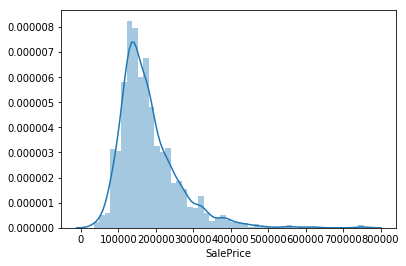

In [36]:
#Check the distribution of Target variable
#not normally distributed -> log transform
sns.distplot(trainData["SalePrice"])

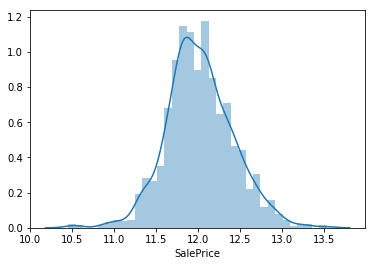

In [37]:
target = np.log1p(trainData.SalePrice)
sns.distplot(target)

In [38]:
#check other numeric variables distribution, if skewness > 0.8, -> log transform
numFeatures = allData.dtypes[allData.dtypes != "object"].index
ind = []
for index in numFeatures:
    skewNum = allData[index].skew()
    if skewNum > 0.8:
        ind.append(index)
allData[ind] = np.log1p(allData[ind])

In [39]:
x_train = allData[:trainData.shape[0]]
y_train = target
x_test = allData[trainData.shape[0]:]
exploreData = pd.concat((x_train, y_train.rename('SalePrice')), axis=1)

##### CorrelationHeatmap, check  multicollinearity,  and correlations between independent variables and dependent variable

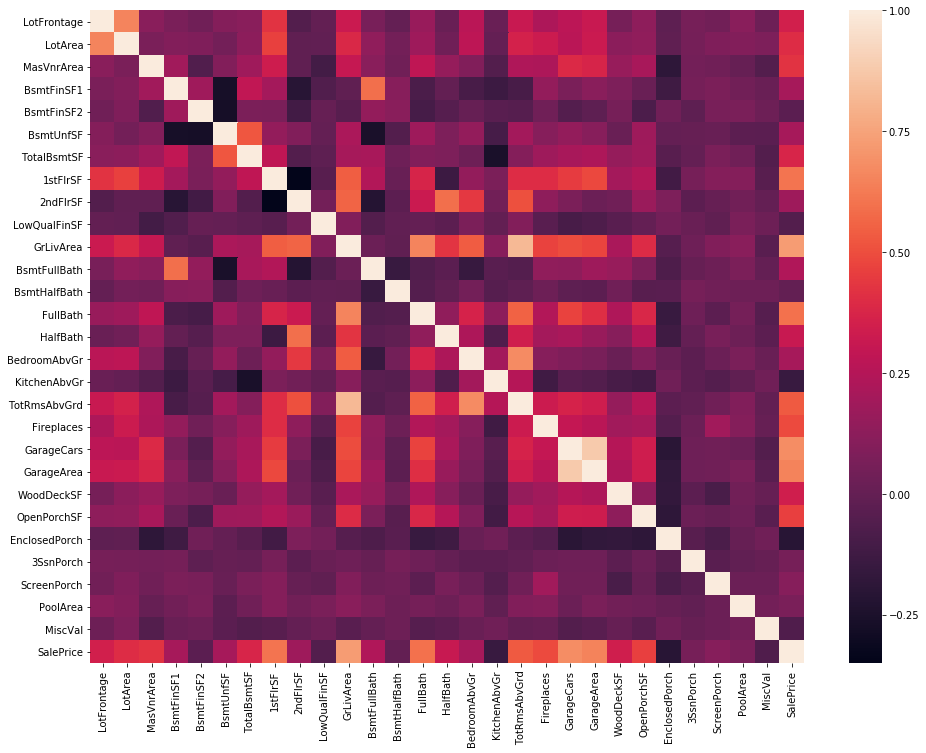

In [40]:
corrMat = exploreData.corr().unstack().sort_values(ascending = False)
corrMat = corrMat[corrMat != 1]
plt.figure(figsize = (16,12))
sns.heatmap(exploreData.corr())
#print(corrMat)
#print(corrMat["SalePrice"])

In [41]:
#drop highly correlated independent features ["GarageArea", "TotRmsAbvGrd"]
corrMat[corrMat >= 0.8]
x_train.drop(["GarageArea","TotRmsAbvGrd"] , axis = 1,  inplace = True)
x_test.drop(["GarageArea","TotRmsAbvGrd"] , axis = 1,  inplace = True)

#### Check the low variance columns  

In [42]:
# drop the columns with low variance (set threshold  = 0.05)
numfea = x_train.dtypes[x_train.dtypes != "object"].index
catfeat =  x_train.columns.symmetric_difference(numfea)
#len(numfea)
#len(catfeat)
from sklearn.feature_selection import VarianceThreshold
VarThre = VarianceThreshold(0.05)
VarThre.fit(x_train[numfea])
newnumfea = x_train[numfea].loc[:,VarThre.get_support(indices=False)]  
lowVar = numfea.symmetric_difference(newnumfea.columns)
x_train.drop(lowVar, axis = 1, inplace = True)
x_test.drop(lowVar, axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### numeric features plot 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


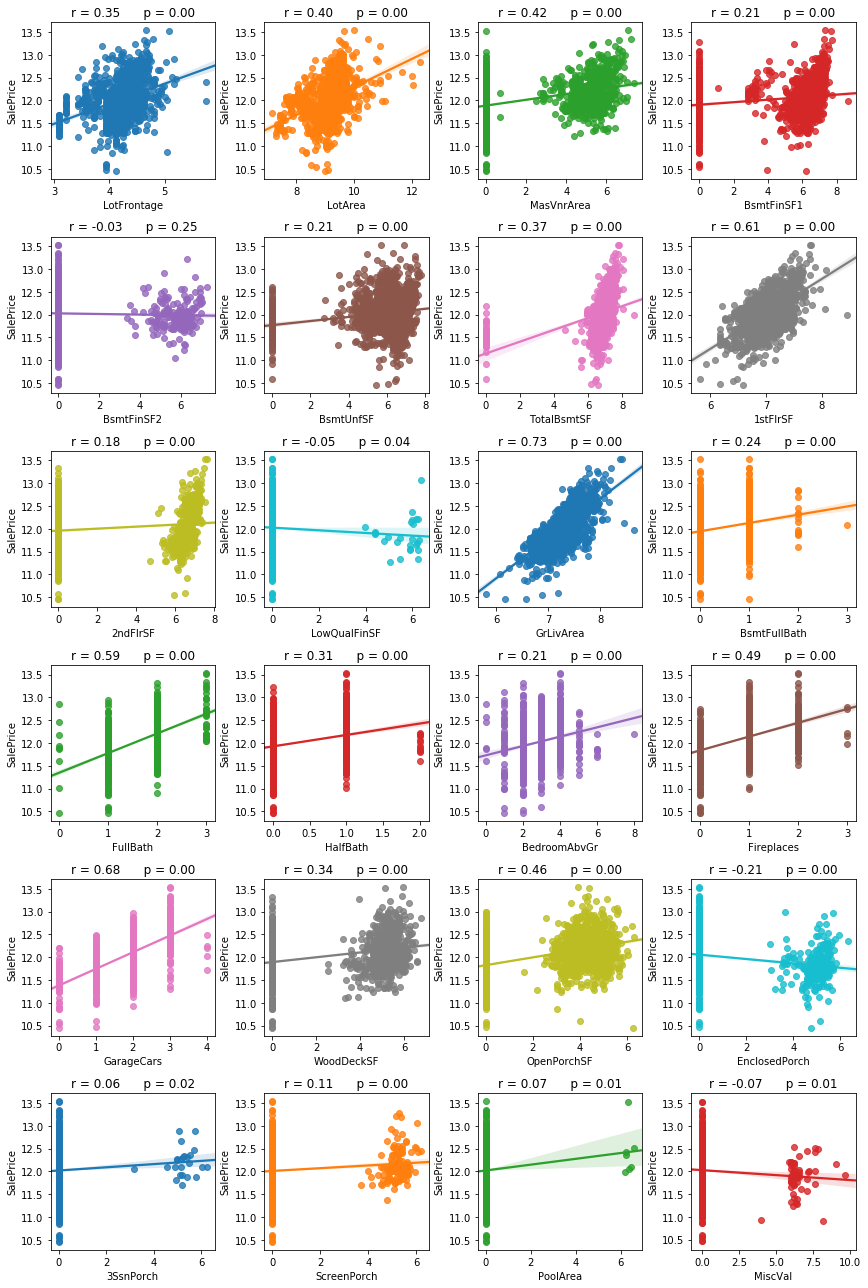

In [43]:

rows = 6
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

numFeaturesNew= list(newnumfea.columns)
for r in range(0,rows):
    for c in range(0,cols):  
        i = r * cols + c
        if i < len(numFeaturesNew):
            sns.regplot(x_train[numFeaturesNew[i]], y_train, ax = axs[r][c])
            stp = stats.pearsonr(x_train[numFeaturesNew[i]], y_train)
            title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(title)
plt.tight_layout()  

#strongly correlated: GrLiveArea, GarageCars, 1stFlrSF, FullBath,FirePlaces, OpenPorchSF
#Many of those strongly-correlated features (eg. FullBath,FirePlaces, OpenPorchSF are correlated with GrLiveArea)

### Categorical features plot 

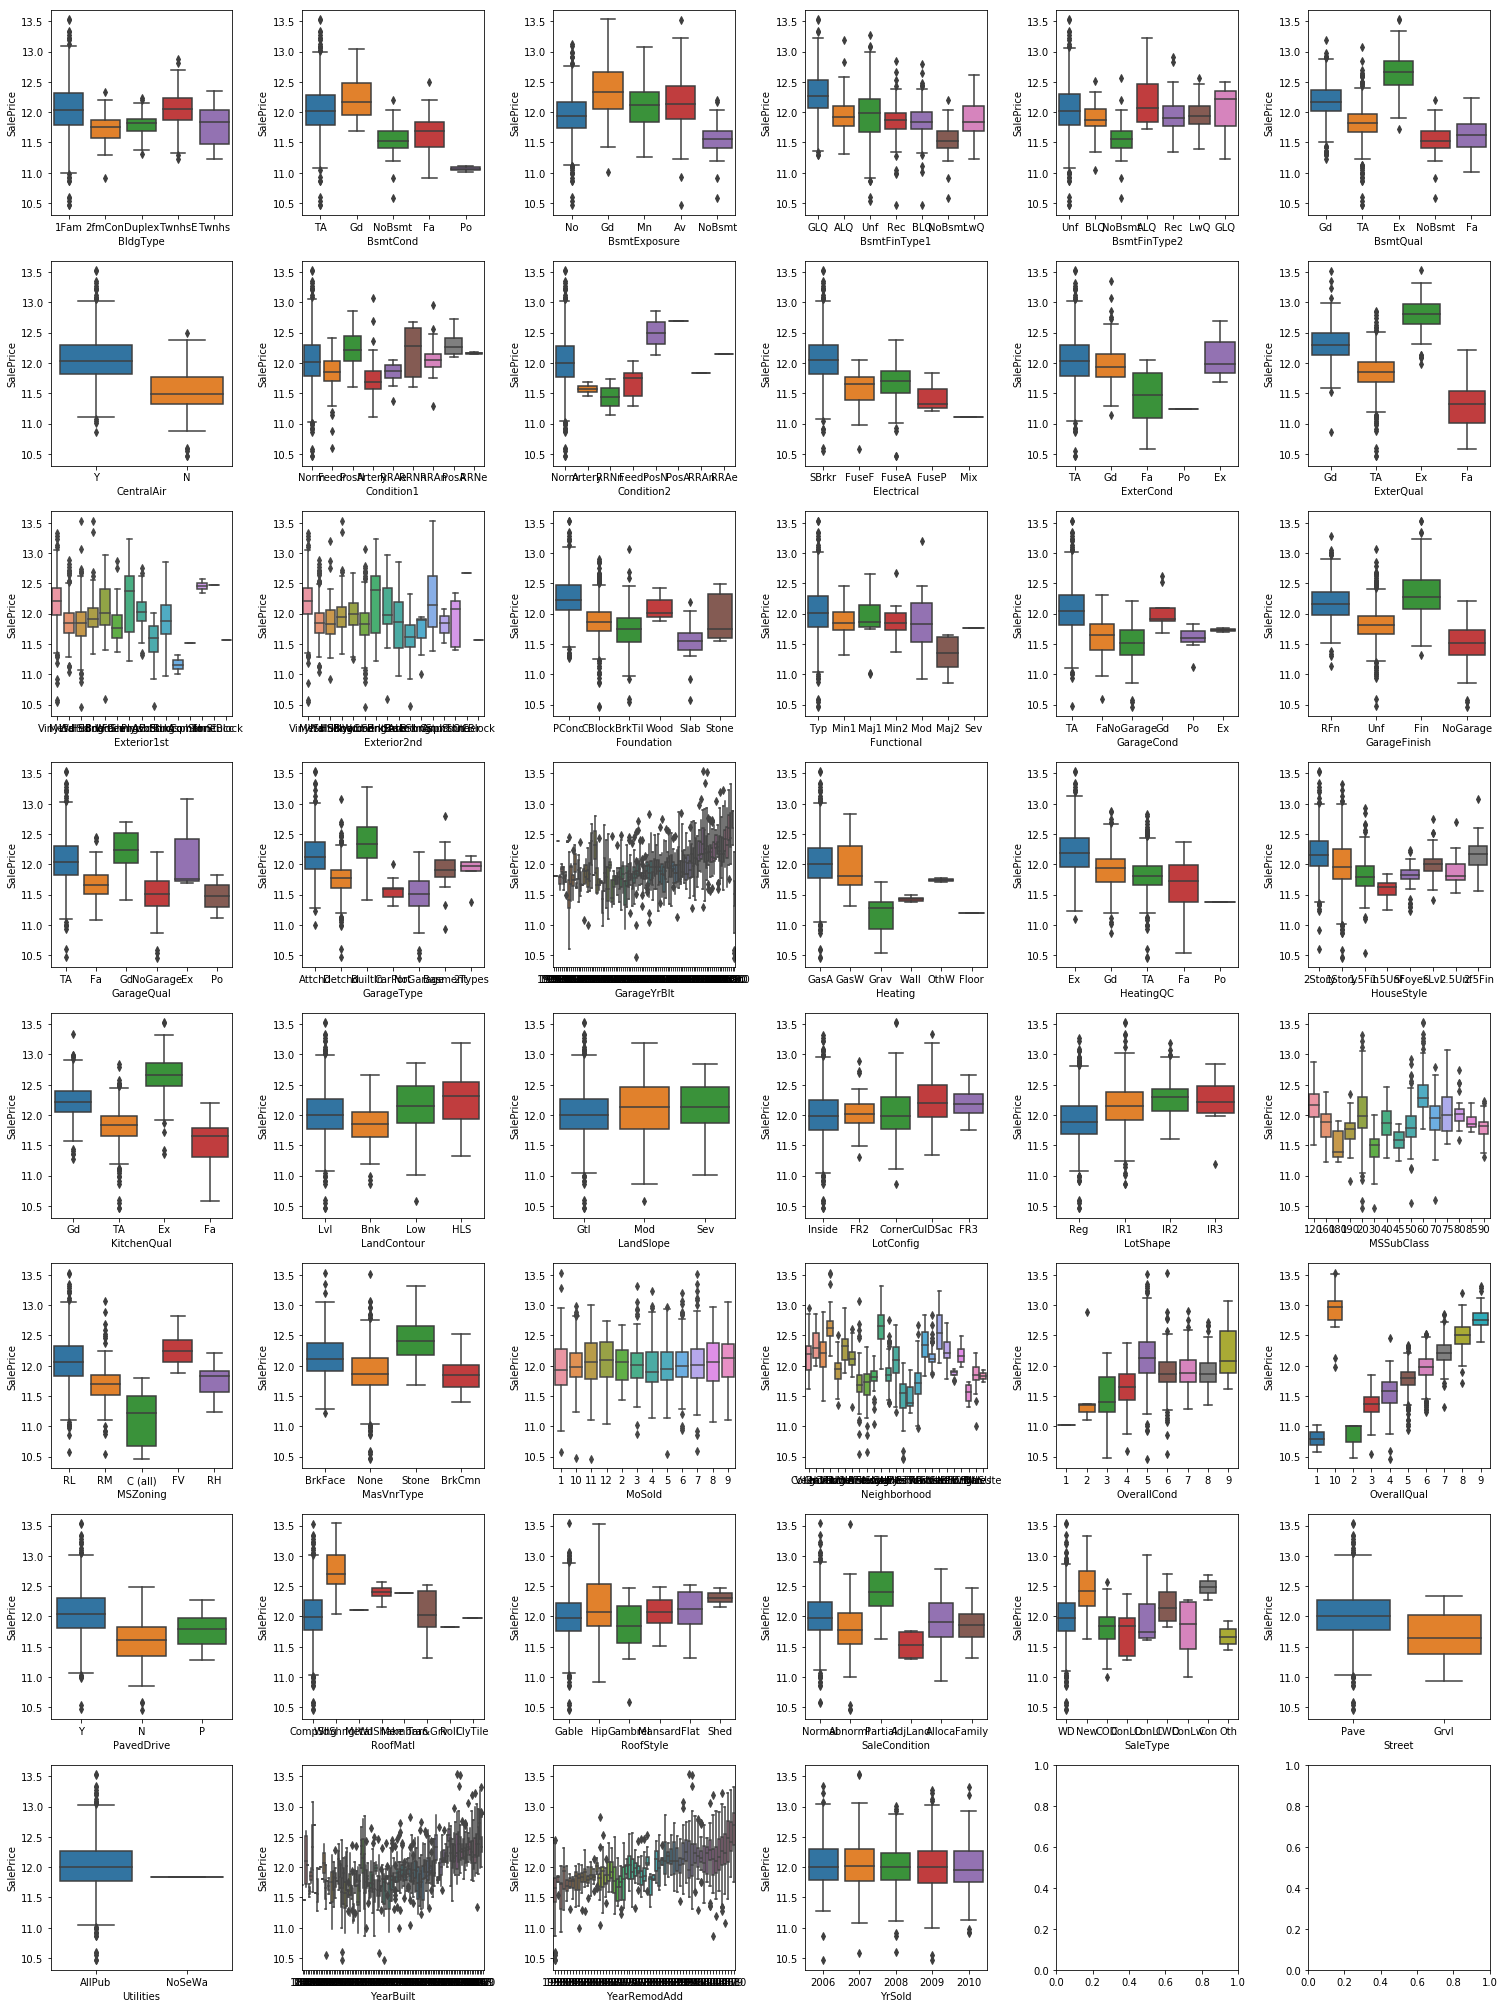

In [44]:
cat_rows = 8
cat_cols = 6
fig, axs = plt.subplots(cat_rows, cat_cols, figsize=(cat_cols * 3.5, cat_rows * 3.5))

catfeat = list(catfeat)
for r in range(0,cat_rows):
    for c in range(0, cat_cols):
        i = r * cat_cols + c
        if i < len(catfeat):
            sns.boxplot(x_train[catfeat[i]], y_train, ax = axs[r][c])
plt.tight_layout()  

#BsmtQual, CentraAir, Condition1, Condition2, Electrical, ExterQual, GarageCond, GarageQual,GarageType, GarageYrBlt,
#KitchenQual, MssubClass, MSZoning, Neighborhood, OverallQual, OverallCond, SaleType

### Outliers detection 

In [45]:
#univariate outliers detection
def outliers_iqr(y):
    q1, q3 = np.percentile(y, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((y > upper_bound) | (y < lower_bound))
temp = outliers_iqr(y_train)
toDrop1 = y_train.iloc[temp].index

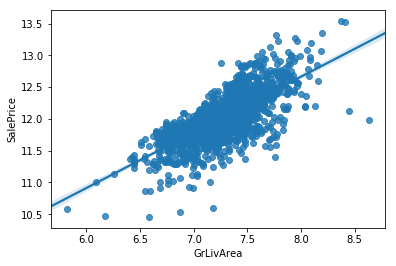

In [46]:
#bivariate outliers detection
sns.regplot(x_train["GrLivArea"], y_train)
toDrop2 = x_train.sort_values("GrLivArea", ascending = False)[:2].index

In [47]:
#Drop outliers
x_train.drop(toDrop1, inplace = True)
y_train.drop(toDrop1,inplace = True)
x_train.drop(toDrop2,inplace = True)
y_train.drop(toDrop2,inplace = True)

### modeling 

In [48]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [49]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

##### Lasso

In [51]:
lassocv = LassoCV(alphas = [1, 0.1, 0.001, 0.0025, 0.005, 0.0005, 0.0001], random_state= 7).fit(x_train, y_train)
nmse_lasso= cross_val_score(lassocv,x_train,y_train, scoring="neg_mean_squared_error", cv = 5)
rmse_lasso = np.sqrt(-nmse_lasso).mean()
print(rmse_lasso)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

0.10561952960453891


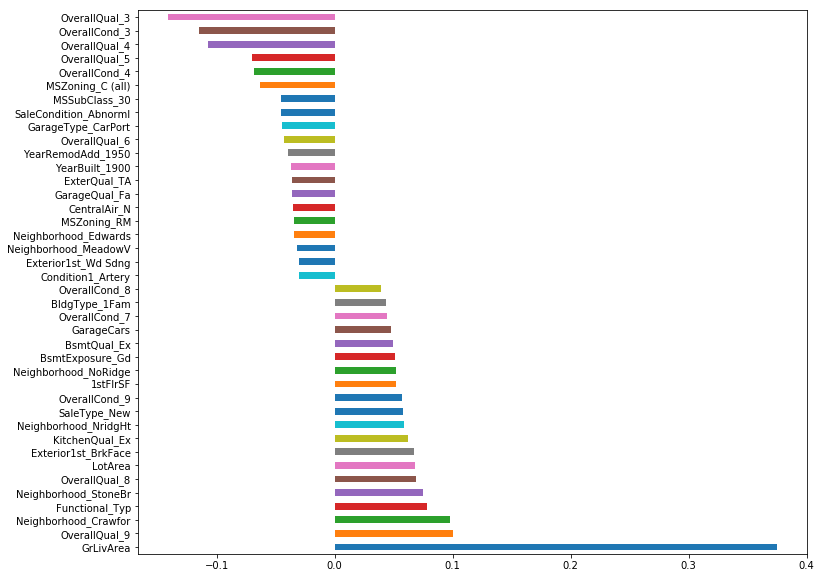

In [52]:
coef = pd.Series(lassocv.coef_, index = x_train.columns)
coef.sort_values(ascending=False, inplace = True)
impCoef = pd.concat((coef.iloc[:20,], coef.iloc[-20:,]))
figure( figsize=(12, 10))
impCoef.plot(kind = "barh")
impFeatures =  coef[coef!=0].index

##### Ridge Regression, features selected based on lasso coef. 

In [56]:
#select feature based on lasso, applying to ridge Regression
x_rid = x_train.loc[:,impFeatures]
#x_rid.shape
ridgecv = RidgeCV(alphas = [50,10,1, 0.1, 0.001, 0.0025, 0.005]).fit(x_rid, y_train)
negmse_rid= cross_val_score(ridgecv,x_rid,y_train, scoring="neg_mean_squared_error", cv = 5)
rmse_rid = np.sqrt(-negmse_rid).mean()
print(rmse_rid)

0.09901410890734735


In [58]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

##### RandomForest 

In [59]:
#Feature Selection
rf = RandomForestRegressor(n_estimators=200, random_state=10, n_jobs=-1)
featuresRF = SelectFromModel(rf)
featuresRF.fit(x_train,y_train)
rfImp = x_train.columns[featuresRF.get_support()]
rf_x_selected = x_train.loc[:, rfImp]

In [64]:
# Tuning HyperParameters
param_grid_rf = {"min_samples_split" : [3,4,6,10], "n_estimators" : [100,200,500,1000], "random_state": [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, refit=True, verbose=1, scoring = "neg_mean_squared_error")
grid_rf.fit(rf_x_selected, y_train)
rmse_rf = np.sqrt(-grid_rf.best_score_)
print(rmse_rf)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.3min finished


0.13911502900099856


#### SGD Regression 

In [65]:
from sklearn.linear_model import SGDRegressor

In [66]:
sgd = SGDRegressor()
sgdsel = SelectFromModel(sgd).fit(x_train, y_train)
sgdFea = x_train.columns[sgdsel.get_support()]
sgd_x_train = x_train.loc[:, sgdFea]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [68]:
para_grid_sgd = {"epsilon":[0.01,0.1,0.5], "alpha":[0.005,0.01,0.05,0.1], "max_iter":[10000]}
grid_sgd = GridSearchCV(sgd, para_grid_sgd, cv=5, verbose=1, scoring = "neg_mean_squared_error", refit = True)
grid_sgd.fit(sgd_x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.0min finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.13911502900099856


In [69]:
rmse_sgd= np.sqrt(-grid_sgd.best_score_)
print(rmse_sgd)

0.13420255268198575


#### Make Prediction -> best model performance:ridge regression

In [74]:
x_test_rid =x_test.loc[:,impFeatures]
#print(x_test.shape, x_rid.shape)
#print(ridgecv.alpha_)
ridgecv = RidgeCV(alphas = [1]).fit(x_rid, y_train)
preds = np.expm1(ridgecv.predict(x_test_rid))